# Finetune the Summary Grader

## Initialize

In [1]:
%%capture
# load packages
from pathlib import Path
import pandas as pd
import numpy as np
!pip install SentencePiece
!pip install "ray[tune]"
!pip install wandb
import seaborn as sns

sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (7.5,3.75),
                  'font.size': 11,
                  'figure.dpi': 300,
                 })

In [2]:
DATA = Path.cwd().parent / 'data'
SUMM_FOLDER = DATA / 'summaries_finetune'
TEXT_FILES = SUMM_FOLDER / 'text_files_copy'
SOURCE_TEXTS = SUMM_FOLDER / 'source_texts'

## Load and clean the data

In [3]:
summaries_df = pd.read_csv(SUMM_FOLDER / 'final_summaries_ai_aloe_fixed.csv')

from sklearn.preprocessing import MinMaxScaler
import numpy as np
  
# copy the data
df_normalized = summaries_df.copy()
  
# apply normalization techniques
df_normalized['content_pca'] = MinMaxScaler().fit_transform(np.array(df_normalized['content_pca']).reshape(-1,1))
df_normalized['paraphrase_pca'] = MinMaxScaler().fit_transform(np.array(df_normalized['paraphrase_pca']).reshape(-1,1))  

In [4]:
df_normalized['text'] = df_normalized['text'] + '</s>' + df_normalized['source']

### Seperate out a test set to avoid prompt effect

In [5]:
source_texts = df_normalized['source_text_filename_clean'].value_counts().to_frame().reset_index()
texts_to_remove = list(source_texts.iloc[15:31]['index'])

In [6]:
# source_texts = df_normalized['source_text'].value_counts().to_frame()
# texts_to_remove = list(source_texts.iloc[1:6].index)

test_df = df_normalized[df_normalized['source_text_filename_clean'].isin(texts_to_remove)]
train_df = df_normalized[df_normalized['source_text_filename_clean'].isin(texts_to_remove) == False]
print('test n:', len(test_df))
print('train n:', len(train_df))

test n: 703
train n: 3987


## Transformer time

In [7]:
from datasets import load_dataset, load_metric, Dataset, Value, ClassLabel, Features, DatasetDict
# from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig, DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig


import torch
seed = 42
model_name = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_name, padding=True, model_max_length = 1024)
#torch.cuda.empty_cache()

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

print(device)

cuda


### Build datasets

In [8]:
def buildDataset(df):
    full_dataset = Dataset.from_pandas(df, preserve_index=False)
    # 70% train, 30% test
    train_valid = full_dataset.train_test_split(test_size=0.176, seed=seed)
    # gather everyone if you want to have a single DatasetDict
    final_dataset = DatasetDict({
        'train': train_valid['train'],
        'valid': train_valid['test']})
    return final_dataset

In [9]:
content_df = train_df[['text', 'content_pca']]
content_df.columns = ['text', 'labels']
content_ds = buildDataset(content_df)

paraphrase_df = train_df[['text', 'paraphrase_pca']]
paraphrase_df.columns = ['text', 'labels']
paraphrase_ds = buildDataset(paraphrase_df)

In [10]:
# this adds the test set in that we seperated earlier
content_ds['test'] = Dataset.from_pandas(test_df[['text', 'content_pca']].rename(columns={'content_pca':'labels', 'text':'text'}), preserve_index=False)
paraphrase_ds['test'] = Dataset.from_pandas(test_df[['text', 'paraphrase_pca']].rename(columns={'paraphrase_pca':'labels', 'text': 'text'}), preserve_index=False)

In [11]:
paraphrase_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 3285
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 702
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 703
    })
})

In [12]:
model_name = model_name
tokenizer = tokenizer

In [13]:
# tokenize them
def tokenize_inputs(example):
    return tokenizer(example['text'], truncation = True)

content_ds_t = content_ds.map(tokenize_inputs, batched=True)
paraphrase_ds_t = paraphrase_ds.map(tokenize_inputs, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [24]:
for i in content_ds_t['train']['input_ids']:
    if len(i) > 1000:
        print(len(i))

1009
1010
1024
1024
1024
1024
1006
1024
1024
1024
1024
1024
1024
1024
1022
1024
1024
1024
1024


In [15]:
tokenizer.decode(content_ds_t['train']['input_ids'][0])

'<s>Food chains are what ecologists use to to show the distribution of energy and matter in an ecosystem. It is in the shape of a pyramid. The bottom is called the autotroph, and is energy from the sun. Energy flows from here to the top, but decreases at each subsequent level. The energy that is lost at each level becomes heat. Population size is often how pyramids are stacked, but that is not always the case. A pyramid of biomass expresses the weight ofliving material at each level.\n</s>Energy and trophic levels: Ecological pyramids \n How can you show how energy is used in an ecosystem? Ecologists use food chains and food webs to model the distribution of matter and energy within an ecosystem. They also use another kind of model, called and ecological pyramid. An ecological pyramid shows how energy flows through an ecosystem. The base of the ecological pyramid represents the autotrophs, or first trophic level. Higher trophic levels are layered on top of one another. The initial sour

### Define metrics

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr 

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

### Set hyperparameters

In [17]:
learning_rate = 3e-05
batch_size = 8
seed = 42
num_epochs = 6
#da_model_name = './results/checkpoint-78500'

# def model_init():
#     return RobertaForSequenceClassification.from_pretrained(model_name,
#                                                               num_labels=1).to(device)
def model_init():
    return LongformerForSequenceClassification.from_pretrained(model_name, num_labels=1).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Train the content model

In [18]:
trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/longformer_content_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    logging_dir = f'./logs/content',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'mse',
    evaluation_strategy = "epoch",
    save_strategy = "epoch", 
    greater_is_better = False,
    seed=seed,
    log_level = 'error',  # took me ages to find these options
    disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
) 

    # Call the Trainer
content_trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = content_ds_t['train'],
    eval_dataset = content_ds_t['valid'],
    compute_metrics = compute_metrics_for_regression,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
content_trainer.train()

loading configuration file https://huggingface.co/allenai/longformer-base-4096/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/0690955d8f70934f95adf0fb108d5f7322d02f8d7dd938b7b133cb7421e120e6.b25f41ff6acdcb7ab47c505c70e351b3fc01957b3798197e5ac6e8efc547ac99
Model config LongformerConfig {
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_head

Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,0.022626,0.022626,0.150418,0.122235,0.451677,20384.606838
2,0.035600,0.011400,0.011400,0.106771,0.080410,0.723722,22685.084046
3,0.019600,0.012641,0.012641,0.112434,0.087286,0.693639,23254.156695
4,0.013100,0.009868,0.009868,0.099337,0.074994,0.760858,21821.722222
5,0.010000,0.009682,0.009682,0.098399,0.073648,0.765351,23071.685185
6,0.010000,0.009298,0.009298,0.096425,0.072082,0.774671,23052.690883


TrainOutput(global_step=2466, training_loss=0.01731401938108149, metrics={'train_runtime': 2740.9272, 'train_samples_per_second': 7.191, 'train_steps_per_second': 0.9, 'total_flos': 9597668387891580.0, 'train_loss': 0.01731401938108149, 'epoch': 6.0})

### Train the paraphrase model

In [19]:
trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/longformer_paraphrase_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    logging_dir = f'./logs/paraphrase',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'mse',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed,
    log_level = 'error', # took me ages to find these options
    disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
) 

    # Call the Trainer
paraphrase_trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = paraphrase_ds_t['train'],
    eval_dataset = paraphrase_ds_t['valid'],
    compute_metrics = compute_metrics_for_regression,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
paraphrase_trainer.train()

loading configuration file https://huggingface.co/allenai/longformer-base-4096/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/0690955d8f70934f95adf0fb108d5f7322d02f8d7dd938b7b133cb7421e120e6.b25f41ff6acdcb7ab47c505c70e351b3fc01957b3798197e5ac6e8efc547ac99
Model config LongformerConfig {
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_head

Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,0.024092,0.024092,0.155217,0.116346,0.368413,24694.034188
2,0.041200,0.020610,0.020610,0.143563,0.104759,0.459695,24967.492877
3,0.025200,0.015796,0.015796,0.125684,0.097173,0.585893,28912.498575
4,0.016500,0.012811,0.012811,0.113187,0.085915,0.664148,28339.136752
5,0.011000,0.012411,0.012411,0.111406,0.085662,0.674636,28882.601140


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Evaluate the models on the test groups

(array([0.8710032450645765], dtype=object), 1.441122304711562e-218)


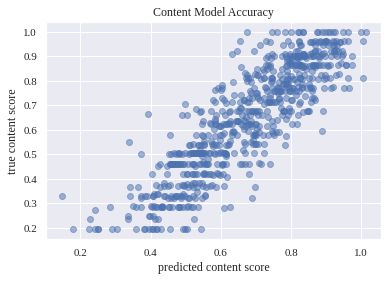

In [20]:
import scipy.stats

con_preds, con_labs, con_metrics = content_trainer.predict(content_ds_t['test'])
con_actual = content_ds_t['test']['labels']
print(scipy.stats.pearsonr(con_actual, con_preds))

from matplotlib import pyplot as plt
con_preds.flatten()
plt.scatter(con_preds, con_actual, alpha=0.5)
plt.ylabel('true content score')
plt.xlabel('predicted content score')
plt.title('Content Model Accuracy')
plt.show()

(array([0.7939531266095243], dtype=object), 1.2152074486705077e-153)


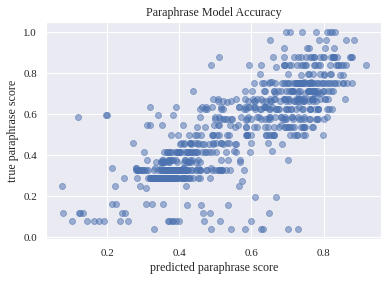

In [21]:
para_preds, para_labs, para_metrics = paraphrase_trainer.predict(paraphrase_ds_t['test'])
paraphrase_actual = paraphrase_ds_t['test']['labels']
print(scipy.stats.pearsonr(paraphrase_actual, para_preds))

from matplotlib import pyplot as plt
para_preds.flatten()
plt.scatter(para_preds, paraphrase_actual, alpha=0.5)
plt.ylabel('true paraphrase score')
plt.xlabel('predicted paraphrase score')
plt.title('Paraphrase Model Accuracy')
plt.show()

In [22]:
# paraphrase_trainer.save_model(SUMM_FOLDER / 'paraphrase_model_longformer')
# content_trainer.save_model(SUMM_FOLDER / 'content_model_longformer')
# tokenizer.save_pretrained(SUMM_FOLDER / 'paraphrase_model_longformer/tokenizer.json')
# tokenizer.save_pretrained(SUMM_FOLDER / 'content_model_longformer/tokenizer.json')